In [ ]:
### copied from: https://github.com/bocchilorenzo/ntscraper
### modified nitter.py by adding function _get_tweet_replies

import requests
from bs4 import BeautifulSoup
import random
from urllib.parse import unquote
from time import sleep
from base64 import b64decode
from random import uniform
from re import match, sub
from datetime import datetime
import logging
from logging.handlers import QueueHandler
from multiprocessing import Pool, Queue, cpu_count
from sys import stdout
from tqdm import tqdm

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(message)s",
    datefmt="%d-%b-%y %H:%M:%S",
    handlers=[logging.StreamHandler(stdout)],
)

log_queue = Queue()
log_handler = QueueHandler(log_queue)
root_logger = logging.getLogger()
root_logger.addHandler(log_handler)

valid_filters = [
    "nativeretweets",
    "media",
    "videos",
    "news",
    "verified",
    "native_video",
    "replies",
    "links",
    "images",
    "safe",
    "quote",
    "pro_video",
]


class Nitter:
    def __init__(self, log_level=1, skip_instance_check=False):
        """
        Nitter scraper

        :param log_level: logging level
        :param skip_instance_check: True if the health check of all instances and the instance change during execution should be skipped
        """
        self.instances = self._get_instances()
        if self.instances is None:
            raise ValueError("Could not fetch instances")
        self.working_instances = []
        self.skip_instance_check = skip_instance_check
        if skip_instance_check:
            self.working_instances = self.instances
        else:
            self._test_all_instances("/x", no_print=True)
        if log_level == 0:
            log_level = logging.WARNING
        elif log_level == 1:
            log_level = logging.INFO
        elif log_level:
            raise ValueError("Invalid log level")

        logger = logging.getLogger()
        logger.setLevel(log_level)

        self.retry_count = 0
        self.cooldown_count = 0
        self.session_reset = False
        self.instance = ""
        self.r = None

    def _initialize_session(self, instance):
        """
        Initialize the requests session
        """
        if instance is None:
            if self.skip_instance_check:
                raise ValueError("No instance specified and instance check skipped")
            self.instance = self.get_random_instance()
            logging.info(
                f"No instance specified, using random instance {self.instance}"
            )
        else:
            self.instance = instance
        self.r = requests.Session()
        self.r.headers.update(
            {
                "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/118.0",
                "Host": self.instance.split("://")[1],
            }
        )

    def _is_instance_encrypted(self):
        """
        Check if the current instance uses encrypted media

        :return: True if encrypted, False otherwise
        """
        soup = self._get_page("/x")

        if soup is None:
            raise ValueError("Invalid instance")

        if (
            soup.find("a", class_="profile-card-avatar").find("img")
            and "/enc/"
            in soup.find("a", class_="profile-card-avatar").find("img")["src"]
        ):
            return True
        else:
            return False

    def _get_instances(self):
        """
        Fetch the list of clear web Nitter instances from the wiki

        :return: list of Nitter instances, or None if lookup failed
        """
        r = requests.get("https://github.com/zedeus/nitter/wiki/Instances")
        instance_list = []
        if r.ok:
            soup = BeautifulSoup(r.text, "lxml")
            official = soup.find_all("tbody")[0]
            instance_list.append(official.find("a")["href"])
            table = soup.find_all("tbody")[2]
            for instance in table.find_all("tr"):
                columns = instance.find_all("td")
                if (columns[1].text.strip() == "✅") and (
                    columns[2].text.strip() == "✅"
                ):
                    instance_list.append(instance.find("a")["href"])
            return instance_list
        else:
            return None

    def _test_all_instances(self, endpoint, no_print=False):
        """
        Test all Nitter instances when a high number of retries is detected

        :param endpoint: endpoint to use
        :param no_print: True if no output should be printed
        """
        if not no_print:
            print("High number of retries detected. Testing all instances...")
        working_instances = []

        for instance in tqdm(self.instances, desc="Testing instances"):
            self._initialize_session(instance)
            req_session = requests.Session()
            req_session.headers.update(
                {
                    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:120.0) Gecko/20100101 Firefox/120.0"
                }
            )
            try:
                r = req_session.get(
                    instance + endpoint,
                    cookies={"hlsPlayback": "on"},
                    timeout=10,
                )
                if r.ok:
                    soup = BeautifulSoup(r.text, "lxml")
                    if soup is not None and len(
                        soup.find_all("div", class_="timeline-item")
                    ):
                        working_instances.append(instance)
            except:
                pass
        if not no_print:
            print("New working instances:", ", ".join(working_instances))
        self.working_instances = working_instances

    def _get_new_instance(self, message):
        instance = self.get_random_instance()
        logging.warning(f"{message}. Trying {instance}")
        return instance
    
    def _check_error_page(self, soup):
        """
        Check if the page contains an error. If so, print the error and return None

        :param soup: page to check
        :return: None if error is found, soup otherwise
        """
        if not soup.find(
            lambda tag: tag.name == "div"
            and (
                tag.get("class") == ["timeline-item"]
                or tag.get("class") == ["timeline-item", "thread"]
            )
        ):
            if soup.find("div", class_="error-panel"):
                message = (
                    f"Fetching error: "
                    + soup.find("div", class_="error-panel").find("span").text.strip()
                )
            else:
                if soup.find("div", class_="timeline-header timeline-protected"):
                    message = "Account is protected"
                else:
                    message = f"Empty page on {self.instance}"
            logging.warning(message)
            soup = None
        return soup

    def _get_page(self, endpoint, max_retries=5):
        """
        Download page from Nitter instance

        :param endpoint: endpoint to use
        :param max_retries: max number of retries, default 5
        :return: page content, or None if max retries reached
        """
        keep_trying = True
        soup = None
        while keep_trying and (self.retry_count < max_retries):
            try:
                r = self.r.get(
                    self.instance + endpoint,
                    cookies={"hlsPlayback": "on", "infiniteScroll": ""},
                    timeout=10,
                )
            except:
                if self.retry_count == max_retries // 2:
                    if not self.skip_instance_check:
                        self._test_all_instances(endpoint)
                        if not self.working_instances:
                            logging.warning(
                                "All instances are unreachable. Check your request and try again."
                            )
                            return None
                if not self.skip_instance_check:
                    self._initialize_session(
                        instance=self._get_new_instance(f"{self.instance} unreachable")
                    )
                self.retry_count += 1
                self.cooldown_count = 0
                self.session_reset = True
                sleep(1)
                continue
            soup = BeautifulSoup(r.text, "lxml")
            if r.ok:
                self.session_reset = False
                soup = self._check_error_page(soup)
                keep_trying = False
            else:
                soup = self._check_error_page(soup)
                if soup is None:
                    keep_trying = False
                else:
                    if self.retry_count == max_retries // 2:
                        if not self.skip_instance_check:
                            self._test_all_instances(endpoint)
                            if not self.working_instances:
                                logging.warning(
                                    "All instances are unreachable. Check your request and try again."
                                )
                                soup = None
                                keep_trying = False
                        else:
                            self.retry_count += 1
                    else:
                        if "cursor" in endpoint:
                            if not self.session_reset:
                                logging.warning(
                                    "Cooldown reached, trying again in 20 seconds"
                                )
                                self.cooldown_count += 1
                                sleep(20)
                            if self.cooldown_count >= 5 and not self.session_reset:
                                if not self.skip_instance_check:
                                    self._initialize_session()
                                else:
                                    self._initialize_session(self.instance)
                                self.session_reset = True
                                self.cooldown_count = 0
                            elif self.session_reset:
                                if not self.skip_instance_check:
                                    self._initialize_session(
                                        self._get_new_instance(
                                            f"Error fetching {self.instance}"
                                        )
                                    )
                        else:
                            self.cooldown_count = 0
                            if not self.skip_instance_check:
                                self._initialize_session(
                                    self._get_new_instance(
                                        f"Error fetching {self.instance}"
                                    )
                                )
                        self.retry_count += 1
            sleep(2)

        if self.retry_count >= max_retries:
            logging.warning("Max retries reached. Check your request and try again.")
            soup = None
        self.retry_count = 0

        return soup

    def _get_quoted_media(self, quoted_tweet, is_encrypted):
        """
        Extract media from a quoted tweet

        :param quoted_tweet: tweet to extract media from
        :param is_encrypted: True if instance uses encrypted media
        :return: lists of images, videos and gifs, or empty lists if no media is found
        """
        quoted_pictures, quoted_videos, quoted_gifs = [], [], []
        if quoted_tweet.find("div", class_="attachments"):
            if is_encrypted:
                quoted_pictures = [
                    "https://pbs.twimg.com/"
                    + b64decode(img["src"].split("/")[-1].encode("utf-8"))
                    .decode("utf-8")
                    .split("?")[0]
                    for img in quoted_tweet.find("div", class_="attachments").find_all(
                        "img"
                    )
                ]
                quoted_videos = [
                    b64decode(video["data-url"].split("/")[-1].encode("utf-8")).decode(
                        "utf-8"
                    )
                    if "data-url" in video.attrs
                    else video.find("source")["src"]
                    for video in quoted_tweet.find(
                        "div", class_="attachments"
                    ).find_all("video", class_="")
                ]
                quoted_gifs = [
                    "https://"
                    + b64decode(
                        gif.source["src"].split("/")[-1].encode("utf-8")
                    ).decode("utf-8")
                    for gif in quoted_tweet.find("div", class_="attachments").find_all(
                        "video", class_="gif"
                    )
                ]
            else:
                quoted_pictures = [
                    "https://pbs.twimg.com"
                    + unquote(img["src"].split("/pic")[1]).split("?")[0]
                    for img in quoted_tweet.find("div", class_="attachments").find_all(
                        "img"
                    )
                ]
                quoted_videos = [
                    unquote("https" + video["data-url"].split("https")[1])
                    if "data-url" in video.attrs
                    else unquote(video.find("source")["src"])
                    for video in quoted_tweet.find(
                        "div", class_="attachments"
                    ).find_all("video", class_="")
                ]
                quoted_gifs = [
                    unquote("https://" + gif.source["src"].split("/pic/")[1])
                    for gif in quoted_tweet.find("div", class_="attachments").find_all(
                        "video", class_="gif"
                    )
                ]
        return quoted_pictures, quoted_videos, quoted_gifs

    def _get_tweet_media(self, tweet, is_encrypted):
        """
        Extract media from a tweet

        :param tweet: tweet to extract media from
        :param is_encrypted: True if instance uses encrypted media
        :return: lists of images, videos and gifs, or empty lists if no media is found
        """
        pictures, videos, gifs = [], [], []
        if tweet.find("div", class_="tweet-body").find(
            "div", class_="attachments", recursive=False
        ):
            if is_encrypted:
                pictures = [
                    "https://pbs.twimg.com/"
                    + b64decode(img["src"].split("/")[-1].encode("utf-8"))
                    .decode("utf-8")
                    .split("?")[0]
                    for img in tweet.find("div", class_="tweet-body")
                    .find("div", class_="attachments", recursive=False)
                    .find_all("img")
                ]
                videos = [
                    b64decode(video["data-url"].split("/")[-1].encode("utf-8")).decode(
                        "utf-8"
                    )
                    if "data-url" in video.attrs
                    else video.find("source")["src"]
                    for video in tweet.find("div", class_="tweet-body")
                    .find("div", class_="attachments", recursive=False)
                    .find_all("video", class_="")
                ]
                gifs = [
                    "https://"
                    + b64decode(
                        gif.source["src"].split("/")[-1].encode("utf-8")
                    ).decode("utf-8")
                    for gif in tweet.find("div", class_="tweet-body")
                    .find("div", class_="attachments", recursive=False)
                    .find_all("video", class_="gif")
                ]
            else:
                pictures = [
                    "https://pbs.twimg.com"
                    + unquote(img["src"].split("/pic")[1]).split("?")[0]
                    for img in tweet.find("div", class_="tweet-body")
                    .find("div", class_="attachments", recursive=False)
                    .find_all("img")
                ]
                videos = [
                    unquote("https" + video["data-url"].split("https")[1])
                    if "data-url" in video.attrs
                    else video.find("source")["src"]
                    for video in tweet.find("div", class_="tweet-body")
                    .find("div", class_="attachments", recursive=False)
                    .find_all("video", class_="")
                ]
                gifs = [
                    unquote("https://" + gif.source["src"].split("/pic/")[1])
                    for gif in tweet.find("div", class_="tweet-body")
                    .find("div", class_="attachments", recursive=False)
                    .find_all("video", class_="gif")
                ]
        return pictures, videos, gifs

    def _get_tweet_stats(self, tweet):
        """
        Extract stats from a tweet

        :param tweet: tweet to extract stats from
        :return: dictionary of stats. If a stat is not found, it is set to 0
        """
        return {
            "comments": int(
                tweet.find_all("span", class_="tweet-stat")[0]
                .find("div")
                .text.strip()
                .replace(",", "")
                or 0
            ),
            "retweets": int(
                tweet.find_all("span", class_="tweet-stat")[1]
                .find("div")
                .text.strip()
                .replace(",", "")
                or 0
            ),
            "quotes": int(
                tweet.find_all("span", class_="tweet-stat")[2]
                .find("div")
                .text.strip()
                .replace(",", "")
                or 0
            ),
            "likes": int(
                tweet.find_all("span", class_="tweet-stat")[3]
                .find("div")
                .text.strip()
                .replace(",", "")
                or 0
            ),
        }

    def _get_user(self, tweet, is_encrypted):
        """
        Extract user from a tweet

        :param tweet: tweet to extract user from
        :param is_encrypted: True if instance uses encrypted media
        :return: dictionary of user
        """
        avatar = ""
        profile_id = ""
        if is_encrypted:
            try:
                avatar = "https://pbs.twimg.com/" + b64decode(
                    tweet.find("img", class_="avatar")["src"]
                    .split("/")[-1]
                    .encode("utf-8")
                ).decode("utf-8")
            except:
                avatar = ""

            if tweet.find("img", class_="avatar"):
                profile_id = (
                    b64decode(
                        tweet.find("img", class_="avatar")["src"]
                        .split("/enc/")[1]
                        .encode("utf-8")
                    )
                    .decode("utf-8")
                    .split("/profile_images/")[1]
                    .split("/")[0]
                )
        else:
            avatar = "https://pbs.twimg.com" + unquote(
                tweet.find("img", class_="avatar")["src"].split("/pic")[1]
            )

            if tweet.find("img", class_="avatar"):
                profile_id = (
                    unquote(tweet.find("img", class_="avatar")["src"])
                    .split("profile_images/")[1]
                    .split("/")[0]
                )
        return {
            "name": tweet.find("a", class_="fullname").text.strip(),
            "username": tweet.find("a", class_="username").text.strip(),
            "profile_id": profile_id,
            "avatar": avatar,
        }

    def _get_tweet_date(self, tweet):
        """
        Extract date from a tweet

        :param tweet: tweet to extract date from
        :return: date of tweet
        """
        return (
            tweet.find("span", class_="tweet-date")
            .find("a")["title"]
            .split("/")[-1]
            .split("#")[0]
            if tweet.find("span", class_="tweet-date")
            else ""
        )

    def _get_tweet_text(self, tweet):
        """
        Extract text from a tweet

        :param tweet: tweet to extract text from
        :return: text of tweet
        """
        return (
            tweet.find("div", class_="tweet-content media-body")
            .text.strip()
            .replace("\n", " ")
            if tweet.find("div", class_="tweet-content media-body")
            else tweet.find("div", class_="quote-text").text.strip().replace("\n", " ")
            if tweet.find("div", class_="quote-text")
            else ""
        )

    def _get_tweet_link(self, tweet):
        """
        Extract link from a tweet

        :param tweet: tweet to extract link from
        :return: link of tweet
        """
        return (
            "https://twitter.com" + tweet.find("a")["href"] if tweet.find("a") else ""
        )

    def _get_tweet_replies(self, tweet):
        """
        Extract @-name from a tweet

        :param tweet: tweet to extract @ from
        :return: @name of tweet reply header
        """
        if tweet.find("div", class_="replying-to"):
            try:
                output = []
                for p in tweet.find("div", class_="replying-to").find_all("a"):
                    output.append(p.text)                
            except:
                output = tweet.find("div", class_="replying-to").find("a").text
        else: output = ""
        return (output)

    def _get_external_link(self, tweet):
        """
        Extract external link from a tweet

        :param tweet: tweet to extract external link from
        :return: external link of tweet
        """
        return (
            tweet.find("a", class_="card-container")["href"]
            if tweet.find("a", class_="card-container")
            else ""
        )

    def _extract_tweet(self, tweet, is_encrypted):
        """
        Extract content from a tweet

        :param tweet: tweet to extract content from
        :param is_encrypted: True if instance uses encrypted media
        :return: dictionary of content for the tweet
        """
        # Replace link text with link
        if tweet.find_all("a"):
            for link in tweet.find_all("a"):
                if "https" in link["href"]:
                    link.replace_with(link["href"])

        # Extract the quoted tweet
        quoted_tweet = (
            tweet.find("div", class_="quote")
            if tweet.find("div", class_="quote")
            else None
        )

        # Extract media from the quoted tweet
        if quoted_tweet:
            deleted = False
            if quoted_tweet["class"] == ["quote", "unavailable"]:
                deleted = True
            (
                quoted_pictures,
                quoted_videos,
                quoted_gifs,
            ) = self._get_quoted_media(quoted_tweet, is_encrypted)

        # is reply
	
	# Extract media from the tweet
        pictures, videos, gifs = self._get_tweet_media(tweet, is_encrypted)

        return {
            "link": self._get_tweet_link(tweet),
            "text": self._get_tweet_text(tweet),
            "user": self._get_user(tweet, is_encrypted),
            "date": self._get_tweet_date(tweet),
            "is-retweet": tweet.find("div", class_="retweet-header") is not None,
            "is-reply": self._get_tweet_replies(tweet),
#            "is-reply": tweet.find("div", class="replying-to") is not None,
            "external-link": self._get_external_link(tweet),
            "quoted-post": {
                "link": self._get_tweet_link(quoted_tweet) if not deleted else "",
                "text": self._get_tweet_text(quoted_tweet) if not deleted else "",
                "user": self._get_user(quoted_tweet, is_encrypted)
                if not deleted
                else {},
                "date": self._get_tweet_date(quoted_tweet) if not deleted else "",
                "pictures": quoted_pictures,
                "videos": quoted_videos,
                "gifs": quoted_gifs,
            }
            if quoted_tweet
            else {},
            "stats": self._get_tweet_stats(tweet),
            "pictures": pictures,
            "videos": videos,
            "gifs": gifs,
        }

    def _check_date_validity(self, date):
        """
        Check if a date is valid

        :param date: date to check
        :return: True if date is valid
        """
        to_return = True
        if not match(r"^\d{4}-\d{2}-\d{2}$", date):
            to_return = False
        try:
            year, month, day = [int(number) for number in date.split("-")]
            datetime(year=year, month=month, day=day)
        except:
            to_return = False

        if not (
            datetime(year=2006, month=3, day=21)
            < datetime(year=year, month=month, day=day)
            <= datetime.now()
        ):
            to_return = False

        return to_return

    def _search(
        self,
        term,
        mode,
        number,
        since,
        until,
        near,
        language,
        to,
        filters,
        exclude,
        max_retries,
        instance,
    ):
        """
        Scrape the specified search terms from Nitter

        :param term: term to seach for
        :param mode: search mode.
        :param number: number of tweets to scrape.
        :param since: date to start scraping from.
        :param until: date to stop scraping at.
        :param near: location to search near.
        :param language: language of the tweets.
        :param to: user to which the tweets are directed.
        :param filters: list of filters to apply.
        :param exclude: list of filters to exclude.
        :param max_retries: max retries to scrape a page.
        :param instance: Nitter instance to use.
        :return: dictionary of tweets and threads for the term.
        """
        tweets = {"tweets": [], "threads": []}
        if mode == "hashtag":
            endpoint = "/search?f=tweets&q=%23" + term
        elif mode == "term":
            endpoint = "/search?f=tweets&q=" + term
        elif mode == "user":
            if since or until:
                endpoint = f"/{term}/search?f=tweets&q="
            else:
                endpoint = f"/{term}"
        else:
            raise ValueError("Invalid mode. Use 'term', 'hashtag', or 'user'.")

        self._initialize_session(instance)

        if language:
            endpoint += f"+lang%3A{language}"

        if to:
            endpoint += f"+to%3A{to}"

        if since:
            if self._check_date_validity(since):
                endpoint += f"&since={since}"
            else:
                raise ValueError(
                    "Invalid 'since' date. Use the YYYY-MM-DD format and make sure the date is valid."
                )

        if until:
            if self._check_date_validity(until):
                endpoint += f"&until={until}"
            else:
                raise ValueError(
                    "Invalid 'until' date. Use the YYYY-MM-DD format and make sure the date is valid."
                )

        if near:
            endpoint += f"&near={near}"

        if filters:
            for f in filters:
                if f not in valid_filters:
                    raise ValueError(
                        f"Invalid filter '{f}'. Valid filters are: {', '.join(valid_filters)}"
                    )
                endpoint += f"&f-{f}=on"

        if exclude:
            for e in exclude:
                if e not in valid_filters:
                    raise ValueError(
                        f"Invalid exclusion filter '{e}'. Valid filters are: {', '.join(valid_filters)}"
                    )
                endpoint += f"&e-{e}=on"

        if mode != "user":
            if "?" in endpoint:
                endpoint += "&scroll=false"
            else:
                endpoint += "?scroll=false"

        soup = self._get_page(endpoint, max_retries)

        if soup is None:
            return tweets

        is_encrypted = self._is_instance_encrypted()

        already_scraped = set()

        number = float("inf") if number == -1 else number
        keep_scraping = True
        while keep_scraping:
            thread = []

            for tweet in soup.find_all("div", class_="timeline-item"):
                if len(tweet["class"]) == 1:
                    to_append = self._extract_tweet(tweet, is_encrypted)
                    # Extract tweets
                    if len(tweets["tweets"]) + len(tweets["threads"]) < number:
                        if self._get_tweet_link(tweet) not in already_scraped:
                            tweets["tweets"].append(to_append)
                            already_scraped.add(self._get_tweet_link(tweet))
                    else:
                        keep_scraping = False
                        break
                else:
                    if "thread" in tweet["class"]:
                        to_append = self._extract_tweet(tweet, is_encrypted)
                        # Extract threads
                        if self._get_tweet_link(tweet) not in already_scraped:
                            thread.append(to_append)
                            already_scraped.add(self._get_tweet_link(tweet))

                        if len(tweet["class"]) == 3:
                            tweets["threads"].append(thread)
                            thread = []

            logging.info(
                f"Current stats for {term}: {len(tweets['tweets'])} tweets, {len(tweets['threads'])} threads..."
            )
            if (
                not (since and until)
                and not (since)
                and len(tweets["tweets"]) + len(tweets["threads"]) >= number
            ):
                keep_scraping = False
            else:
                sleep(uniform(1, 2))

                # Go to the next page
                show_more_buttons = soup.find_all("div", class_="show-more")
                if soup.find_all("div", class_="show-more"):
                    if mode == "user":
                        if since or until:
                            next_page = (
                                f"/{term}/search?"
                                + show_more_buttons[-1].find("a")["href"].split("?")[-1]
                            )
                        else:
                            next_page = (
                                f"/{term}?"
                                + show_more_buttons[-1].find("a")["href"].split("?")[-1]
                            )
                    else:
                        next_page = "/search" + show_more_buttons[-1].find("a")["href"]
                    soup = self._get_page(next_page, max_retries)
                    if soup is None:
                        keep_scraping = False
                else:
                    keep_scraping = False
        return tweets

    def _search_dispatch(self, args):
        return self._search(*args)

    def get_random_instance(self):
        """
        Get a random Nitter instance

        :return: URL of random Nitter instance
        """
        return random.choice(self.working_instances)

    def get_tweets(
        self,
        terms,
        mode="term",
        number=-1,
        since=None,
        until=None,
        near=None,
        language=None,
        to=None,
        filters=None,
        exclude=None,
        max_retries=5,
        instance=None,
    ):
        """
        Scrape the specified term from Nitter

        :param terms: string/s to search for
        :param mode: search mode. Default is 'term', can also be 'hashtag' or 'user'
        :param number: number of tweets to scrape. Default is -1 (to not set a limit).
        :param since: date to start scraping from, formatted as YYYY-MM-DD. Default is None
        :param until: date to stop scraping at, formatted as YYYY-MM-DD. Default is None
        :param near: near location of the tweets. Default is None (anywhere)
        :param language: language of the tweets. Default is None (any language)
        :param to: user to which the tweets are directed. Default is None (any user)
        :param filters: list of filters to apply. Default is None
        :param exclude: list of filters to exclude. Default is None
        :param max_retries: max retries to scrape a page. Default is 5
        :param instance: Nitter instance to use. Default is None
        :return: dictionary or array with dictionaries (in case of multiple terms) of the tweets and threads for the provided terms
        """
        if type(terms) == str:
            term = terms.strip()

            return self._search(
                term,
                mode,
                number,
                since,
                until,
                near,
                language,
                to,
                filters,
                exclude,
                max_retries,
                instance,
            )
        elif len(terms) == 1:
            term = terms[0].strip()

            return self._search(
                term,
                mode,
                number,
                since,
                until,
                near,
                language,
                to,
                filters,
                exclude,
                max_retries,
                instance,
            )
        else:
            if len(terms) > cpu_count():
                raise ValueError(
                    f"Too many terms. Maximum number of terms is {cpu_count()}"
                )

            args = [
                (
                    term.strip(),
                    mode,
                    number,
                    since,
                    until,
                    near,
                    language,
                    to,
                    filters,
                    exclude,
                    max_retries,
                    instance,
                )
                for term in terms
            ]
            with Pool(len(terms)) as p:
                results = list(p.map(self._search_dispatch, args))

            return results

    def get_profile_info(self, username, max_retries=5, instance=None):
        """
        Get profile information for a user

        :param username: username of the page to scrape
        :param max_retries: max retries to scrape a page. Default is 5
        :param instance: Nitter instance to use. Default is None
        :return: dictionary of the profile's information
        """
        self._initialize_session(instance)
        username = sub(r"[^A-Za-z0-9_+-:]", "", username)
        soup = self._get_page(f"/{username}", max_retries)
        if soup is None:
            return None

        is_encrypted = self._is_instance_encrypted()
        # Extract id if the banner exists, no matter if the instance uses base64 or not
        if soup.find("div", class_="profile-banner").find("img") and is_encrypted:
            profile_id = (
                b64decode(
                    soup.find("div", class_="profile-banner")
                    .find("img")["src"]
                    .split("/enc/")[1]
                    .encode("utf-8")
                )
                .decode("utf-8")
                .split("/profile_banners/")[1]
                .split("/")[0]
            )
        elif soup.find("div", class_="profile-banner").find("img"):
            profile_id = (
                unquote(soup.find("div", class_="profile-banner").find("img")["src"])
                .split("profile_banners/")[1]
                .split("/")[0]
            )
        else:
            profile_id = ""

        # Extract profile image, no matter if the instance uses base64 or not
        if soup.find("a", class_="profile-card-avatar").find("img") and is_encrypted:
            profile_image = "https://" + b64decode(
                soup.find("a", class_="profile-card-avatar")
                .find("img")["src"]
                .split("/enc/")[1]
                .encode("utf-8")
            ).decode("utf-8")
        elif soup.find("a", class_="profile-card-avatar").find("img"):
            profile_image = (
                "https://"
                + unquote(
                    soup.find("a", class_="profile-card-avatar").find("img")["src"]
                ).split("/pic/")[1]
            )
        else:
            profile_image = ""

        icon_container = (
            soup.find("div", class_="photo-rail-header").find(
                "div", class_="icon-container"
            )
            if soup.find("div", class_="photo-rail-header")
            else None
        )

        return {
            "image": profile_image,
            "name": soup.find("a", class_="profile-card-fullname").text.strip(),
            "username": soup.find("a", class_="profile-card-username").text.strip(),
            "id": profile_id,
            "bio": soup.find("div", class_="profile-bio").p.text.strip()
            if soup.find("div", class_="profile-bio")
            else "",
            "location": soup.find("div", class_="profile-location")
            .find_all("span")[-1]
            .text.strip()
            if soup.find("div", class_="profile-location")
            else "",
            "website": soup.find("div", class_="profile-website").find("a")["href"]
            if soup.find("div", class_="profile-website")
            else "",
            "joined": soup.find("div", class_="profile-joindate").find("span")["title"],
            "stats": {
                "tweets": int(
                    soup.find("ul", class_="profile-statlist")
                    .find("li", class_="posts")
                    .find_all("span")[1]
                    .text.strip()
                    .replace(",", "")
                ),
                "following": int(
                    soup.find("ul", class_="profile-statlist")
                    .find("li", class_="following")
                    .find_all("span")[1]
                    .text.strip()
                    .replace(",", "")
                ),
                "followers": int(
                    soup.find("ul", class_="profile-statlist")
                    .find("li", class_="followers")
                    .find_all("span")[1]
                    .text.strip()
                    .replace(",", "")
                ),
                "likes": int(
                    soup.find("ul", class_="profile-statlist")
                    .find("li", class_="likes")
                    .find_all("span")[1]
                    .text.strip()
                    .replace(",", "")
                ),
                "media": int(
                    icon_container.text.strip().replace(",", "").split(" ")[0]
                    if icon_container
                    else 0
                ),
            },
        }


In [ ]:
scraper = Nitter(log_level=1, skip_instance_check=False)

In [ ]:
import os
os.getcwd()

In [ ]:
import pandas as pd

MetzTilly = scraper.get_tweets("MetzTilly", mode='user', since='2020-01-01')

MetzTilly_tweets = []

for tweet in MetzTilly['tweets']:
    data = [tweet['link'], tweet['date'], tweet['stats']['retweets'], tweet['stats']['likes'], tweet['stats']['comments'], tweet['stats']['quotes'], tweet['text'], tweet['is-reply'], tweet['is-retweet']]
    MetzTilly_tweets.append(data)

data8 = pd.DataFrame(MetzTilly_tweets, columns = ['link', 'date', 'retweets', 'likes', 'comments', 'quotes', 'text', 'replied-to', 'retweet'])
data8.to_csv('MetzTilly_tweets.csv')


In [ ]:
len(data8)

In [ ]:
check = data8['replied-to'].tolist()

In [ ]:
import pandas as pd

AWIntergroup = scraper.get_tweets("AWIntergroup", mode='user', since='2020-01-01')

AWIntergroup_tweets = []

for tweet in AWIntergroup['tweets']:
    data = [tweet['link'], tweet['date'], tweet['stats']['retweets'], tweet['stats']['likes'], tweet['stats']['comments'], tweet['stats']['quotes'], tweet['text'], tweet['is-reply'], tweet['is-retweet']]
    AWIntergroup_tweets.append(data)

data9 = pd.DataFrame(AWIntergroup_tweets, columns = ['link', 'date', 'retweets', 'likes', 'comments', 'quotes', 'text', 'replied-to', 'retweet'])
data9.to_csv('AWIntergroup_tweets.csv')


In [ ]:
len(data9)

In [ ]:
import pandas as pd

Act4AnimalsEU = scraper.get_tweets("Act4AnimalsEU", mode='user', since='2020-01-01')

Act4AnimalsEU_tweets = []

for tweet in Act4AnimalsEU['tweets']:
    data = [tweet['link'], tweet['date'], tweet['stats']['retweets'], tweet['stats']['likes'], tweet['stats']['comments'], tweet['stats']['quotes'], tweet['text'], tweet['is-reply'], tweet['is-retweet']]
    Act4AnimalsEU_tweets.append(data)

data10 = pd.DataFrame(Act4AnimalsEU_tweets, columns = ['link', 'date', 'retweets', 'likes', 'comments', 'quotes', 'text', 'replied-to', 'retweet'])
data10.to_csv('Act4AnimalsEU_tweets.csv')

In [ ]:
len(data10)

In [ ]:
import pandas as pd

LadyFreethinker = scraper.get_tweets("LadyFreethinker", mode='user', since='2020-01-01')

LadyFreethinker_tweets = []

for tweet in LadyFreethinker['tweets']:
    data = [tweet['link'], tweet['date'], tweet['stats']['retweets'], tweet['stats']['likes'], tweet['stats']['comments'], tweet['stats']['quotes'], tweet['text'], tweet['is-reply'], tweet['is-retweet']]
    LadyFreethinker_tweets.append(data)

data11 = pd.DataFrame(LadyFreethinker_tweets, columns = ['link', 'date', 'retweets', 'likes', 'comments', 'quotes', 'text', 'replied-to', 'retweet'])
data11.to_csv('LadyFreethinker_tweets.csv')

In [ ]:
len(data11)

In [ ]:
import pandas as pd

ProtectWldlife = scraper.get_tweets("ProtectWldlife", mode='user', since='2020-01-01')

ProtectWldlife_tweets = []

for tweet in ProtectWldlife['tweets']:
    data = [tweet['link'], tweet['date'], tweet['stats']['retweets'], tweet['stats']['likes'], tweet['stats']['comments'], tweet['stats']['quotes'], tweet['text'], tweet['is-reply'], tweet['is-retweet']]
    ProtectWldlife_tweets.append(data)

data12 = pd.DataFrame(ProtectWldlife_tweets, columns = ['link', 'date', 'retweets', 'likes', 'comments', 'quotes', 'text', 'replied-to', 'retweet'])
data12.to_csv('ProtectWldlife_tweets.csv')

In [ ]:
data12.columns

In [15]:
import pandas as pd

data8 = pd.read_csv('MetzTilly_tweets.csv')
data9 = pd.read_csv('AWIntergroup_tweets.csv')
data10 = pd.read_csv('Act4AnimalsEU_tweets.csv')
data11 = pd.read_csv('LadyFreethinker_tweets.csv')
data12 = pd.read_csv('ProtectWldlife_tweets.csv')

In [16]:
import demoji

data8['text'] = data8.text.astype(str).apply(lambda x: demoji.replace(x,' '))
data9['text'] = data9.text.astype(str).apply(lambda x: demoji.replace(x,' '))
data10['text'] = data10.text.astype(str).apply(lambda x: demoji.replace(x,' '))
data11['text'] = data11.text.astype(str).apply(lambda x: demoji.replace(x,' '))
data12['text'] = data12.text.astype(str).apply(lambda x: demoji.replace(x,' '))

In [21]:
import re
import string

remove = string.punctuation
remove = remove.replace("@", "") # don't remove hyphens
pattern = r"[{}]".format(remove) # create the pattern
#re.sub(pattern, "", txt)
#data16 = [re.sub('\S*@\S*\s?', '', sent) for sent in data16]
#df["new_column"] = df['review'].str.replace('[^\w\s]','')
data8['text'] = data8.text.replace(pattern, ' ',regex=True).astype(str)
data9['text'] = data9.text.replace(pattern, ' ',regex=True).astype(str)
data10['text'] = data10.text.replace(pattern, ' ',regex=True).astype(str)
data11['text'] = data11.text.replace(pattern, ' ',regex=True).astype(str)
data12['text'] = data12.text.replace(pattern, ' ',regex=True).astype(str)

In [23]:
def extractize(float1):
    str1 = str(float1)
    lst2 = [word for word in str1.split() if word.startswith('@')]
    return lst2

data8['ats'] = data8['text'].apply(extractize)
data9['ats'] = data9.text.apply(extractize)
data10['ats'] = data10.text.apply(extractize)
data11['ats'] = data11.text.apply(extractize)
data12['ats'] = data12.text.apply(extractize)

In [24]:
temp8a = data8.ats.tolist()
temp9a = data9.ats.tolist()
temp10a = data10.ats.tolist()
temp11a = data11.ats.tolist()
temp12a = data12.ats.tolist()

In [26]:
data8['replied-to'].fillna('', inplace = True)
data9['replied-to'].fillna('', inplace = True)
data10['replied-to'].fillna('', inplace = True)
data11['replied-to'].fillna('', inplace = True)
data12['replied-to'].fillna('', inplace = True)

In [ ]:
## optional
MT = data8[['ats','replied-to']]
AW = data9[['ats','replied-to']]

In [ ]:
### optional

MT['ats'] = MT.ats.astype(str)
AW['ats'] = AW.ats.astype(str)

In [ ]:
### optional

MT['comb'] = MT['ats'] + MT['replied-to']

In [ ]:
### optional

AW['comb'] = AW['ats'] + AW['replied-to']

In [ ]:
### optional

len(AW)

In [ ]:
### optional

MT['len'] = MT.apply(lambda row: len(row.comb), axis=1)
AW['len'] = AW.apply(lambda row: len(row.comb), axis=1)

In [ ]:
### optional

MT[MT.len > 2]

In [27]:
temp8b = data8['replied-to'].tolist()
temp9b = data9['replied-to'].tolist()
temp10b = data10['replied-to'].tolist()
temp11b = data11['replied-to'].tolist()
temp12b = data12['replied-to'].tolist()

In [28]:
temp8b = [x for x in temp8b if x]
temp9b = [x for x in temp9b if x]
temp10b = [x for x in temp10b if x]
temp11b = [x for x in temp11b if x]
temp12b = [x for x in temp12b if x]

In [29]:
from ast import literal_eval

temp8b = [literal_eval(x) for x in temp8b]
temp9b = [literal_eval(x) for x in temp9b]
temp10b = [literal_eval(x) for x in temp10b]
temp11b = [literal_eval(x) for x in temp11b]
temp12b = [literal_eval(x) for x in temp12b]

In [30]:
temp8b

[['@EMamyline'],
 ['@MetzTilly', '@GreensEFA'],
 ['@MetzTilly', '@GreensEFA'],
 ['@vanderbeeken',
  '@GreensEFA',
  '@gruffat_claude',
  '@BenoitBiteau',
  '@MartinHaeusling',
  '@arche__noah',
  '@ECVC1',
  '@prieler_m',
  '@wienerofficial',
  '@EUAgri'],
 ['@M00000',
  '@GreensEFA',
  '@gruffat_claude',
  '@BenoitBiteau',
  '@wienerofficial',
  '@MartinHaeusling'],
 ['@rcofinof'],
 ['@CIWF_EU'],
 ['@wirtzbill',
  '@CHansenEU',
  '@CSV_news',
  '@deigreng',
  '@MarcAngel_lu',
  '@MonicaSemedoLux',
  '@iwiseler',
  '@CharlesGoerens',
  '@lsap_lu',
  '@dp_lu'],
 ['@CHansenEU',
  '@CSV_news',
  '@deigreng',
  '@MarcAngel_lu',
  '@MonicaSemedoLux',
  '@iwiseler',
  '@CharlesGoerens',
  '@lsap_lu',
  '@dp_lu'],
 ['@MetzTilly',
  '@TBIJ',
  '@MargreteAuken',
  '@MicheleRivasi',
  '@rosadamato634',
  '@HAImedicines',
  '@EU_Commission'],
 ['@MetzTilly',
  '@TBIJ',
  '@GreensEFA',
  '@MargreteAuken',
  '@MicheleRivasi',
  '@rosadamato634',
  '@HAImedicines'],
 ['@MetzTilly', '@TBIJ'],
 ['@Met

In [31]:
MetzTilly = []
AWIntergroup = [] 
Act4AnimalsEU = []
LadyFreethinker = []
ProtectWldlife = []

In [32]:
[MetzTilly.extend(x) for x in temp8a]
[AWIntergroup.extend(x) for x in temp9a]
[Act4AnimalsEU.extend(x) for x in temp10a]
[LadyFreethinker.extend(x) for x in temp11a]
[ProtectWldlife.extend(x) for x in temp12a]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [33]:
[MetzTilly.extend(x) for x in temp8b]
[AWIntergroup.extend(x) for x in temp9b]
[Act4AnimalsEU.extend(x) for x in temp10b]
[LadyFreethinker.extend(x) for x in temp11b]
[ProtectWldlife.extend(x) for x in temp12b]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [34]:
MetzTilly

['@epc',
 '@EU',
 '@EPP',
 '@tillymetz',
 '@Europarl',
 '@BArevalodeLeon',
 '@KarinHerreraVP',
 '@vonderleyen',
 '@YouTube',
 '@AWintergroup',
 '@Europarl',
 '@AWintergroup',
 '@EUCouncil',
 '@BArevalodeLeon',
 '@EU',
 '@EU',
 '@GreensEFA',
 '@EU',
 '@CarlosErnesto',
 '@WHO',
 '@GreensEFA',
 '@EU',
 '@michelerivasi',
 '@EP',
 '@gruffat',
 '@BenoitBiteau',
 '@wienerofficial',
 '@MartinHaeusling',
 '@EP',
 '@ERA',
 '@AWintergroup',
 '@SKyriakidesEU',
 '@AWintergroup',
 '@SKyriakidesEU',
 '@wienerofficial',
 '@GreensEFA',
 '@Europarl',
 '@EPPGroup',
 '@AWintergroup',
 '@SKyriakidesEU',
 '@TheLancet',
 '@GreensEFA',
 '@EU',
 '@vonderleyen',
 '@EU',
 '@Europarl',
 '@Europarl',
 '@OGBL',
 '@UE',
 '@EP',
 '@EP',
 '@Europarl',
 '@OGBL',
 '@UE',
 '@Europarl',
 '@UN',
 '@POLITICOEurope',
 '@CESIunions',
 '@Cgfp',
 '@CESIunions',
 '@Cgfp',
 '@LoroParque',
 '@FGuerreiroMEP',
 '@anjahazekamp',
 '@EPPGroup',
 '@EU',
 '@EP',
 '@wienerofficial',
 '@MartinHaeusling',
 '@gruffat',
 '@BenoitBiteau',
 '@e

In [35]:
unique_MetzTilly = list(set(MetzTilly))
unique_AWIntergroup = list(set(AWIntergroup))
unique_Act4AnimalsEU = list(set(Act4AnimalsEU))
unique_LadyFreethinker = list(set(LadyFreethinker))
unique_ProtectWldlife = list(set(ProtectWldlife))

In [36]:
repeat_MetzTilly = ['@MetzTilly'] * len(unique_MetzTilly)
repeat_AWIntergroup = ['@AWIntergroup'] * len(unique_AWIntergroup)
repeat_Act4AnimalsEU = ['@Act4AnimalsEU'] * len(unique_Act4AnimalsEU)
repeat_LadyFreethinker = ['@LadyFreethinker'] * len(unique_LadyFreethinker)
repeat_ProtectWldlife = ['@ProtectWldlife'] * len(unique_ProtectWldlife)

In [37]:
tuple_MetzTilly = list(zip(repeat_MetzTilly, unique_MetzTilly))
tuple_AWIntergroup = list(zip(repeat_AWIntergroup, unique_AWIntergroup))
tuple_Act4AnimalsEU = list(zip(repeat_Act4AnimalsEU, unique_Act4AnimalsEU))
tuple_LadyFreethinker = list(zip(repeat_LadyFreethinker, unique_LadyFreethinker))
tuple_ProtectWldlife = list(zip(repeat_ProtectWldlife, unique_ProtectWldlife))

In [38]:
import networkx as nx

#e = [(1,2),(1,3),(2,3)]
G = nx.Graph()

G.add_edges_from(tuple_MetzTilly)
G.add_edges_from(tuple_AWIntergroup)
G.add_edges_from(tuple_Act4AnimalsEU)
G.add_edges_from(tuple_LadyFreethinker)
G.add_edges_from(tuple_ProtectWldlife)

print(G)

Graph with 3436 nodes and 3940 edges


In [39]:
# https://www.kaggle.com/code/mayeesha/network-analysis-for-dummies-stackoverflow-data

sorted_cliques = sorted(list(nx.find_cliques(G)),key=len)

max_clique_nodes = set()

for nodelist in sorted_cliques[-4:-1]:
    for node in nodelist:
        max_clique_nodes.add(node)

max_clique = G.subgraph(max_clique_nodes)

#print(nx.info(max_clique))

In [40]:
import matplotlib.pyplot as plt

def draw_graph(G):
    nodes = G.nodes()
#    color_map = {1:'#f09494', 2:'#eebcbc', 3:'#72bbd0', 4:'#91f0a1', 5:'#629fff', 6:'#bcc2f2',  
#             7:'#eebcbc', 8:'#f1f0c0', 9:'#d2ffe7', 10:'#caf3a6', 11:'#ffdf55', 12:'#ef77aa', 
#             13:'#d6dcff', 14:'#d2f5f0'}
#    node_color= [color_map[d['group']] for n,d in G.nodes(data=True)]
#    node_size = [d['nodesize']*10 for n,d in G.nodes(data=True)]
    pos = nx.drawing.spring_layout(G,k=0.70,iterations=60)
    plt.figure()
    nx.draw_networkx(G,pos=pos,edge_color='#FFDEA2')
    plt.show()

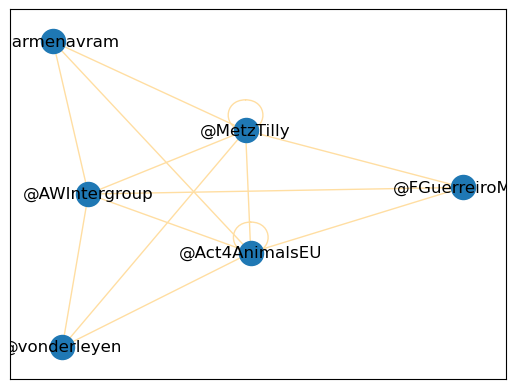

In [41]:
draw_graph(max_clique)

In [43]:
remove = [node for node,degree in dict(G.degree()).items() if degree < 5]
G.remove_nodes_from(remove)
list(G)

['@MetzTilly',
 '@Act4AnimalsEU',
 '@ciwf',
 '@AWIntergroup',
 '@LadyFreethinker',
 '@ProtectWldlife']

In [ ]:
### optional

all = []
all.extend(MetzTilly)
all.extend(AWIntergroup)
all.extend(Act4AnimalsEU)
all.extend(LadyFreethinker)
all.extend(ProtectWldlife)

In [ ]:
### optional
unique_list = list(set(all))
len(unique_list)

In [ ]:
### optional

import pandas as pd

data = pd.read_csv('aw_global_csv.csv')
compare1 = data.username.tolist()

compare2 = list(set(compare1))
len(compare2)

In [ ]:
### optional

lst2 = [x for x in compare2 if x in unique_list]
print(len(lst2))

In [ ]:
print(len(MetzTilly), len(AWIntergroup), len(Act4AnimalsEU), len(LadyFreethinker), len(ProtectWldlife))

In [ ]:
### optional
import pandas as pd

followers = pd.read_csv('result_followers_AWIntergroup.csv')
following = pd.read_csv('result_following_AWIntergroup.csv')

In [ ]:
### optional
unique_AWIntergroup = [w.replace('@', '') for w in unique_AWIntergroup]

In [ ]:
### optional
followers = followers.screenName.unique().tolist()
following = following.screenName.unique().tolist()

In [ ]:
### optional

print(len(unique_AWIntergroup), len(followers), len(following))

In [ ]:
### optional

lst3 = [x for x in followers if x in unique_AWIntergroup]
lst4 = [x for x in following if x in unique_AWIntergroup]
print(len(lst3), len(lst4))

In [ ]:
MetzTilly = pd.read_csv('MetzTilly_tweets.csv')
AWIntergroup = pd.read_csv('AWIntergroup_tweets.csv')
Act4AnimalsEU = pd.read_csv('Act4AnimalsEU_tweets.csv')
LadyFreethinker = pd.read_csv('LadyFreethinker_tweets.csv')
ProtectWldlife = pd.read_csv('ProtectWldlife_tweets.csv')